<a href="https://colab.research.google.com/github/rafisondi/ml-playground/blob/main/GaussianProcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [111]:
x = np.linspace(0, 1 , 1000)
x_measurement = np.sort( np.random.uniform(0.2,0.8,20) ) #x[::5]
var = 0.05

In [112]:
def function(x):
    return 1*x + x**2 + np.cos(3*x)

def noisy_function(x):
    return function(x) + np.random.normal(0, var , len(x))

def corr_function(x):
    return np.asarray( [1, x, x**2 , x**3 , np.cos(3*x) ,np.cos(4*x)] , dtype = "object")

def linear_kernel(x1, x2):
    return corr_function(x1).T @ corr_function(x2)

def prior_mean_function(x):
    return 1*x**2





In [113]:
f_values = function(x)
y_values = noisy_function(x_measurement)

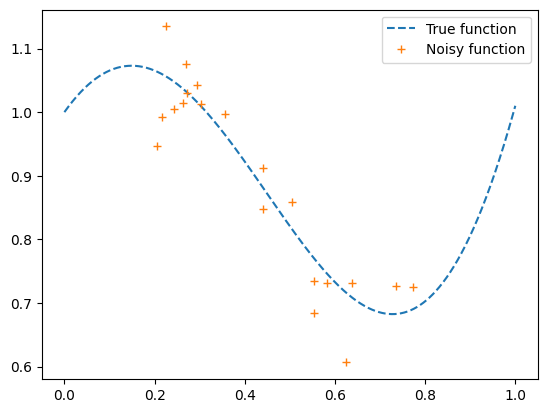

In [114]:
plt.figure()
plt.plot(x,f_values , '--')
plt.plot(x_measurement, y_values, '+')
plt.legend(['True function', 'Noisy function'])
plt.show()

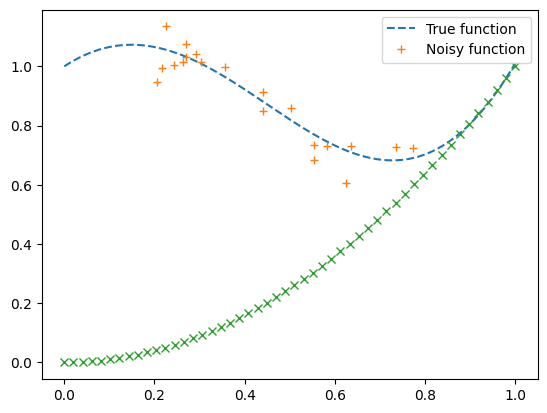

In [115]:
## Inference points

x_inference = np.array(np.linspace(0,1,50))
intial_model_inference = prior_mean_function(x_inference)

plt.figure()
plt.plot(x,f_values , '--')
plt.plot(x_measurement, y_values, '+')
plt.plot(x_inference, intial_model_inference, 'x' , label = 'Prior function estimates')
plt.legend(['True function', 'Noisy function'])
plt.show()

In [116]:
# Gaussian process
mu = prior_mean_function(x_inference)
mu_prior = prior_mean_function(x_measurement)

K_matrix = np.zeros( [x_measurement.shape[0] , x_measurement.shape[0]] )
for i in range(K_matrix.shape[0]):
    for j in range(K_matrix.shape[1]):
        K_matrix[i,j] = linear_kernel(x_measurement[i], x_measurement[j])

def k_column(x, x_values):
    k_column = np.zeros( [x_values.shape[0] , x_inference.shape[0]] )
    for i in range(x_values.shape[0]):
        k_column[i] = linear_kernel(x, x_values[i])
    return k_column


k_xA = k_column(x_inference, x_measurement)
mu_new = mu.reshape(-1,1) + k_xA.T @ np.linalg.inv(K_matrix + var * np.identity(K_matrix.shape[0])) @ (y_values - mu_prior).reshape(-1,1)

col_xA = k_column(x_inference, x_measurement)
col_xx = k_column(x_inference, x_inference)

variance_diag = col_xx - col_xA.T @ np.linalg.inv(K_matrix + var * np.identity(K_matrix.shape[0])) @ col_xA
variance_diag = np.diag(variance_diag)
std_dev = np.sqrt(variance_diag)
confidence_interval = 1.96 * std_dev


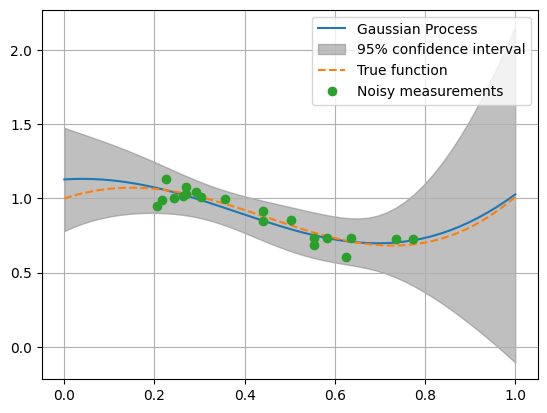

In [117]:
plt.figure()

plt.plot(x_inference, mu_new, label='Gaussian Process')
plt.fill_between(x_inference,
                 (mu_new.squeeze() - confidence_interval),
                 (mu_new.squeeze() + confidence_interval),
                 color='gray', alpha=0.5, label='95% confidence interval')

plt.plot(x, f_values, '--', label='True function')
plt.plot(x_measurement, y_values, 'o', label='Noisy measurements')
plt.legend()
plt.grid()
plt.show()